# Create crystal structure for ML from stable structure 

1. obtain stable structure from materials project
2. create supercell
3. randomly displace atoms while compressing or expanding the cell

In [1]:
# load ASE atom from POSCAR file
from ase.io.vasp import read_vasp
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np

from ase import Atoms
from ase.neighborlist import NeighborList
from ase.build import make_supercell

from ovito.modifiers import CoordinationAnalysisModifier
from ovito.pipeline import StaticSource, Pipeline
from ovito.io.ase import ase_to_ovito

from mlptools.data.structures import generate_crystal
from mlptools.io.write import QuantumEspressoWriter

def get_rdf(ase_atoms, rcut=6, bins=100) -> np.ndarray:
    """get radial distribution function val

    Args:
        rcut (int, optional): cutoff radius. Defaults to 6.
        bins (int, optional): _description_. Defaults to 100.

    Returns:
        np.ndarray: 1st: distance, 2nd: rdf value
    """
    pipeline = Pipeline(source = StaticSource(data=ase_to_ovito(ase_atoms)))
    # modifier = CoordinationAnalysisModifier(cutoff=rcut, number_of_bins=bins, partial=True)
    modifier = CoordinationAnalysisModifier(cutoff=rcut, number_of_bins=bins)
    pipeline.modifiers.append(modifier)
    rdf_table = pipeline.compute().tables['coordination-rdf']
    return rdf_table

In [3]:
# randomly displace atoms while compressing or expanding the cell
path2POSCAR = '/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-733790/original/POSCAR'
original_atoms = read_vasp(path2POSCAR)

In [4]:
print(len(original_atoms.positions))

72


In [7]:
displacement_list = np.linspace(0.05, 0.20, 20)
scale_list = np.linspace(0.6, 1.5, 100)
num_samples = 30000

all_atoms = []
for i in range(num_samples):
    # show progress
    if i % 100 == 0:
        print(f"{i}/ {num_samples}")
    displacement = np.random.choice(displacement_list)
    scale = np.random.choice(scale_list)
    atoms = generate_crystal(original_atoms, displacement, scale, supercell_mtx=[[1,0,0],[0,1,0],[0,0,1]])
    all_atoms.append(atoms)

0/ 30000
100/ 30000
200/ 30000
300/ 30000
400/ 30000
500/ 30000
600/ 30000
700/ 30000
800/ 30000
900/ 30000
1000/ 30000
1100/ 30000
1200/ 30000
1300/ 30000
1400/ 30000
1500/ 30000
1600/ 30000
1700/ 30000
1800/ 30000
1900/ 30000
2000/ 30000
2100/ 30000
2200/ 30000
2300/ 30000
2400/ 30000
2500/ 30000
2600/ 30000
2700/ 30000
2800/ 30000
2900/ 30000
3000/ 30000
3100/ 30000
3200/ 30000
3300/ 30000
3400/ 30000
3500/ 30000
3600/ 30000
3700/ 30000
3800/ 30000
3900/ 30000
4000/ 30000
4100/ 30000
4200/ 30000
4300/ 30000
4400/ 30000
4500/ 30000
4600/ 30000
4700/ 30000
4800/ 30000
4900/ 30000
5000/ 30000
5100/ 30000
5200/ 30000
5300/ 30000
5400/ 30000
5500/ 30000
5600/ 30000
5700/ 30000
5800/ 30000
5900/ 30000
6000/ 30000
6100/ 30000
6200/ 30000
6300/ 30000
6400/ 30000
6500/ 30000
6600/ 30000
6700/ 30000
6800/ 30000
6900/ 30000
7000/ 30000
7100/ 30000
7200/ 30000
7300/ 30000
7400/ 30000
7500/ 30000
7600/ 30000
7700/ 30000
7800/ 30000
7900/ 30000
8000/ 30000
8100/ 30000
8200/ 30000
8300/ 30000
8400

In [12]:
rdf_list = []
distance = get_rdf(all_atoms[0], bins=150).xy()[:, 0]
for atoms in all_atoms:
    rdf_list.append(get_rdf(atoms, bins=150).xy()[:, 1])

rdf_list = np.array(rdf_list)

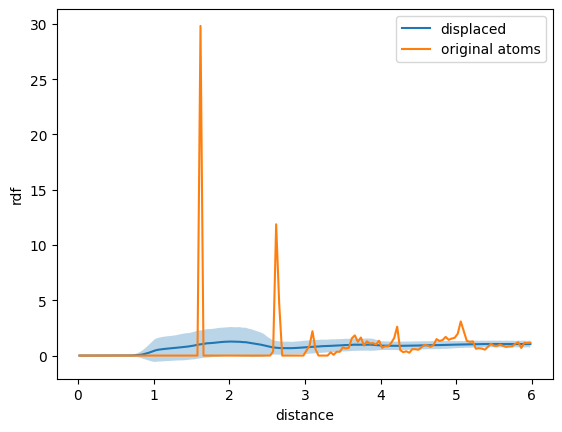

In [13]:
# plot rdf
fig, ax = plt.subplots()
ax.plot(distance, rdf_list.mean(axis=0), label='displaced')
ax.fill_between(distance, rdf_list.mean(axis=0) - rdf_list.std(axis=0), rdf_list.mean(axis=0) + rdf_list.std(axis=0), alpha=0.3)

# plot original atoms rdf
original_atoms_rdf = get_rdf(original_atoms, bins=150).xy()
ax.plot(original_atoms_rdf[:, 0], original_atoms_rdf[:, 1], label='original atoms')
ax.legend()
ax.set_xlabel('distance')
ax.set_ylabel('rdf')
plt.show()

In [14]:
import pickle

path2save = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-733790/atoms"
for i, atoms in enumerate(all_atoms):
    path2target = os.path.join(path2save, f"ase_atoms_{i}")
    if not os.path.exists(path2target):
        os.makedirs(path2target)
    # save atoms as pkl
    with open(os.path.join(path2target, "atoms.pkl"), 'wb') as f:
        pickle.dump(atoms, f)

In [15]:
path_scf_input_template = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-733790/input"
path_root_result = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-733790/result"

with open(f'{path_scf_input_template}/scf.in') as f:
    original_scf_input_lines = [s.strip() for s in f.readlines()]

for i, atoms in enumerate(all_atoms):
    writer = QuantumEspressoWriter(atoms, path_scf_input_template)
    scf_input_lines = writer.output()

    # create dir
    path2result = f'{path_root_result}/scf_{i}'
    if not os.path.exists(path2result):
        os.makedirs(path2result)
    else:
        print(f'{path2result} already exists')

    # write scf.in
    with open(f'{path2result}/scf.in', 'w') as f:
        f.writelines('\n'.join(scf_input_lines))

In [ ]:
from glob import glob
import os
import subprocess
import random

n_parallel = 40
path2root = "/home/y1u0d2/result/qe/Si/amorphous/result/01"
scf_dirs = glob(f'{path2root}/scf*')

# shuffle list
random.shuffle(scf_dirs)

for scf_dir in scf_dirs:
    if os.path.exists(f'{scf_dir}/scf.out'):
        print(f'{scf_dir}/scf.out already exists')
        continue
    try:
        process = subprocess.Popen(
        f'mpiexec.hydra -n {n_parallel} -machine $TMPDIR/machines pw.x -in {scf_dir}/scf.in > {scf_dir}/scf.out',
        shell=True)
        process.wait()  
    except:
        continue

In [ ]:
from glob import glob
import os
import shutil

path2result = "/home/y1u0d2/result/qe/SiO2/mp-546794/result"
path2save = "/home/y1u0d2/result/qe/SiO2/mp-546794/send_20230902"

dirs = glob(f"{path2result}/scf*")

for d in dirs:
    path2target = os.path.join(d, "scf.out")
    if os.path.exists(path2target):
        # copy d to path2save with shutil
        shutil.copytree(d, os.path.join(path2save, os.path.basename(d)))
        print(f"[SUCCESS] {os.path.basename(d)} is copied")
    else:
        print(f"[FAILED] {os.path.basename(d)} is not copied")

In [ ]:
from glob import glob
import os

path2target = " /sqfs/work/G15529/v60746/result/qe/SiO2/mp-733790/result"
dirs = glob(f"{path2target}/scf*")

print(len(dirs))
count = 0
for d in dirs:
    if os.path.exists(f"{d}/scf.out"):
        count += 1